In [1]:
from scipy import stats
from selenium import webdriver
from bootstrap import *
from rp_data import *
from web import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

In [7]:
#Value pitching for last 5 years:
#This table includes stats for all pitchers and their salaries
for num in range(2015, 2020):
 html = get_html(f'https://www.baseball-reference.com/leagues/MLB/{num}-value-pitching.shtml')
 table = pd.read_html(html)
 table[-1].to_csv(f'data/{num}-value.csv')

#Reliever stats for the last 5 years:
#This table includes stats for only relief pitchers
for num in range(2015, 2020):
  html = get_html(f'https://www.baseball-reference.com/leagues/MLB/{num}-reliever-pitching.shtml')
  table = pd.read_html(html)
  table[-1].to_csv(f'data/{num}-reliever.csv')

#Saving locally as CSV files since the table layout and data changes day to day

In [2]:
#Now that I have the data saved as CSV files, I want to collect all the file names as a list
#to easily read all of them into a panda database.

relievers_csv = glob.glob('data/*-reliever*')
relievers_csv.sort(reverse=True)
salaries_csv = glob.glob('data/*-value*')
salaries_csv.sort(reverse=True)

print(relievers_csv)
print(salaries_csv)

['data/2019-reliever.csv', 'data/2018-reliever.csv', 'data/2017-reliever.csv', 'data/2016-reliever.csv', 'data/2015-reliever.csv']
['data/2019-value.csv', 'data/2018-value.csv', 'data/2017-value.csv', 'data/2016-value.csv', 'data/2015-value.csv']


In [3]:
#Extracting file names into a list

relievers = []
salaries = []

for file in relievers_csv:
    path, filename = os.path.split(file)
    year = re.findall('\d\d\d\d', filename)[0] #find only strings of 4 digits
    temp_df = pd.read_csv(file)
    temp_df['file_year'] = year #append year as a column to file as a reference
    relievers.append(temp_df)

for file in salaries_csv:
    path, filename = os.path.split(file)
    year = re.findall('\d\d\d\d', filename)[0]
    temp_df = pd.read_csv(file)
    temp_df['file_year'] = year
    salaries.append(temp_df)

In [4]:
relievers[0].head()

,Unnamed: 0,Rk,Name,Age,Tm,IP,G,GR,GF,Wgr,...,Bhd,Runr,Empt,>3o,<3o,IPmult,0DR,Out/GR,Pit/GR,file_year
0,0,1,Fernando Abad*,33,SFG,8.2,13,13,1,0,...,6,8,5,1,8,2,3,2.0,9,2019
1,1,2,Bryan Abreu,22,HOU,3.0,2,2,1,0,...,1,0,2,1,0,1,0,4.5,25,2019
2,2,3,Jason Adam,27,TOR,14.2,14,14,1,1,...,7,5,9,3,4,5,2,3.1,20,2019
3,3,4,Austin Adams,32,TOT,16.2,15,15,9,0,...,12,2,13,4,2,4,3,3.3,21,2019
4,4,5,Austin Adams,32,MIN,2.2,2,2,1,0,...,0,0,2,1,1,1,0,4.0,37,2019


In [15]:
salaries[0].head()

,Unnamed: 0,Rk,Name,Age,Tm,IP,G,GS,R,RA9,...,WAA,gmLI,WAAadj,WAR,RAR,waaWL%,162WL%,Salary,Acquired,file_year
0,0,1,Fernando Abad*,33,SFG,8.2,13,0,5,5.19,...,-0.1,1.65,0.0,-0.1,0,.494,.499,"$100,000",Free Agency,2019
1,1,2,Bryan Abreu,22,HOU,3.0,2,0,0,0.00,...,0.2,.01,-0.1,0.1,2,.581,.501,NaN,Amateur Free Agent,2019
2,2,3,Jason Adam,27,TOR,14.2,14,0,8,4.91,...,0.0,1.24,0.0,0.1,2,.501,.500,NaN,Purchased,2019
3,3,4,Austin Adams,32,2TM,16.2,15,0,13,7.02,...,-0.3,.33,0.1,0.0,-2,.481,.500,NaN,Waivers,2019
4,4,5,Austin Adams,28,2TM,28.0,25,2,11,3.54,...,0.4,1.28,0.0,0.7,7,.515,.503,NaN,Traded,2019


In [5]:
def clean_df(df):
  '''
  Function for cleaning up df for rows with values that have column names as str type.
  The tables scraped from baseball-reference consist of multiple tables joined together
  and the column names have been repeatedly scraped as row entries.
  Remove pitchers with NaN values on salary as there is no way to quantify their value in this study
  Select columns have useful values
  '''
  if 'Salary' in df:
    df.dropna(subset = ['Salary'], inplace=True)
  df = df[df['Name'] != 'Name']
  col_names = ['Name','Age','Tm', 'G_x', 'GR', 'SV%', 'IS%','RA9', 'RAA', 'RAR', 'WAA', 'WAR', 'file_year_x', 'file_year_y', 'Salary']
  df = df[col_names].reset_index(drop=True)
  df.rename(columns ={"IP_x":"IP", "G_x": "G"}, inplace=True)
  df['GR%'] = df['GR'].astype(int)/df['G'].astype(int)
  return df

def merge_df(df1, df2):
  '''
  df1, df2 = reliever and value dfs
  Merge the dfs using inner join because pitchers from {year}-value df includes all pitchers, starters and relievers.
  This way, it will eliminate all the non-relievers by only merging rows under pitchers listed in the reliever df.
  '''
  return pd.merge(df1, df2, how='inner', on =['Name', 'Age', 'Tm'])


In [6]:
#creating the dfs per year and cleaning them

dfs = [clean_df(merge_df(r, s)) for r, s in zip(relievers, salaries)]

In [7]:
dfs[0].head()

,Name,Age,Tm,G,GR,SV%,IS%,RA9,RAA,RAR,WAA,WAR,file_year_x,file_year_y,Salary,GR%
0,Fernando Abad*,33,SFG,13,13,NaN,23%,5.19,-1,0,-0.1,-0.1,2019,2019,"$100,000",1.0
1,Chance Adams,24,NYY,10,10,33%,33%,7.61,-8,-6,-0.8,-0.4,2019,2019,"$556,725",1.0
2,Ehire Adrianza,29,MIN,1,1,NaN,NaN,27.00,-2,-2,-0.2,-0.1,2019,2019,"$1,300,000",1.0
3,Matt Albers,36,MIL,62,62,80%,23%,5.11,-4,1,-0.4,-0.1,2019,2019,"$2,500,000",1.0
4,Hanser Alberto,26,BAL,1,1,NaN,NaN,18.00,-1,-1,-0.1,-0.1,2019,2019,"$578,000",1.0


In [23]:
# I see that even after using inner join, 
# there are some starting pitchers that have entered the game in relief on occasion and may skew the data.

# I already made a column GR/G, and will now exclude those that have entered a game in relief less 
# than 50% of the time

#Panda query to see if exclusion will work as intended

dfs[0][dfs[0]['GR%'] < .50]


,Name,Age,Tm,G,GR,SV%,IS%,RA9,RAA,RAR,WAA,WAR,file_year_x,file_year_y,Salary,GR%
11,Chase Anderson,31,MIL,28,5,NaN,0%,4.73,3,13,0.3,1.2,2019,2019,"$6,500,000",0.178571
20,Manny Banuelos*,28,CHW,14,6,NaN,20%,7.52,-12,-6,-1.1,-0.6,2019,2019,"$559,000",0.428571
30,Shane Bieber,24,CLE,31,1,NaN,NaN,3.45,31,53,3.2,4.9,2019,2019,"$559,600",0.032258
37,Steven Brault*,27,PIT,22,6,NaN,NaN,4.40,10,19,1.1,1.9,2019,2019,"$574,500",0.272727
51,Carlos Carrasco,32,CLE,16,4,0%,NaN,5.61,-5,3,-0.5,0.2,2019,2019,"$9,750,000",0.250000
62,Yonny Chirinos,25,TBR,23,6,NaN,0%,3.91,14,29,1.4,2.6,2019,2019,"$561,800",0.260870
71,Dylan Covey,27,CHW,17,6,0%,80%,8.02,-15,-9,-1.4,-0.9,2019,2019,"$571,000",0.352941
80,Ross Detwiler*,33,CHW,15,6,NaN,100%,7.29,-10,-4,-0.9,-0.4,2019,2019,"$100,000",0.400000
92,Zach Eflin,25,PHI,28,4,NaN,NaN,4.89,3,15,0.3,1.4,2019,2019,"$590,000",0.142857
93,Jerad Eickhoff,28,PHI,12,2,100%,NaN,5.71,-5,0,-0.4,0.1,2019,2019,"$975,000",0.166667


In [30]:
# Also going to exclude pitchers with 5 or less games played. 
# It looks like there are a lot of position players who have pitched a couple of times 
# when their team is blown out that may skew the performance stats.
dfs[0][dfs[0]['GR'].astype(int) < 5]

,Name,Age,Tm,G,GR,SV%,IS%,RA9,RAA,RAR,WAA,WAR,file_year_x,file_year_y,Salary,GR%
2,Ehire Adrianza,29,MIN,1,1,NaN,NaN,27.00,-2,-2,-0.2,-0.1,2019,2019,"$1,300,000",1.000000
4,Hanser Alberto,26,BAL,1,1,NaN,NaN,18.00,-1,-1,-0.1,-0.1,2019,2019,"$578,000",1.000000
8,Aaron Altherr,28,PHI,1,1,NaN,NaN,9.00,0,0,0.0,0.0,2019,2019,"$1,350,000",1.000000
12,Cody Anderson,28,CLE,5,3,0%,67%,9.35,-5,-4,-0.4,-0.6,2019,2019,"$641,250",0.600000
15,Pedro Araujo,25,BAL,1,1,NaN,NaN,27.00,-2,-2,-0.1,-0.1,2019,2019,"$557,000",1.000000
16,Alex Avila,32,ARI,2,2,NaN,NaN,4.50,0,0,0.0,0.0,2019,2019,"$4,250,000",1.000000
19,Anthony Banda*,25,TBR,1,1,NaN,NaN,9.00,-1,0,-0.1,0.0,2019,2019,"$556,800",1.000000
24,Tony Barnette,35,CHC,2,2,NaN,0%,6.75,0,0,0.0,0.0,2019,2019,"$750,000",1.000000
30,Shane Bieber,24,CLE,31,1,NaN,NaN,3.45,31,53,3.2,4.9,2019,2019,"$559,600",0.032258
49,Victor Caratini,25,CHC,2,2,NaN,NaN,9.00,-1,-1,-0.1,0.0,2019,2019,"$569,500",1.000000


In [8]:
#function to remove the data within the parameters stated above
def exclusion(df):
    return df[(df['GR%'] > .50) & (df['GR'].astype(int) > 5)]

dfs = [exclusion(df) for df in dfs]

In [9]:
#Need to make the data usable for statistical tests later

#Salary needs to have the $ and , characters removed and converted to int

#Other columns just need to be changed from str type to float.

#SV% and IS% are edge cases that I sorted out later because there wasn't an easy solution to the NaN values

def salary_to_int(df):
  df['Salary'] = df['Salary'].replace('[$,]', '', regex=True).astype(int)

def column_to_num(df, col_name, type=float):
  df[col_name] = df[col_name].astype(type)

col_names = ['RAA','RAR', 'RA9', 'WAA', 'WAR']

for df in dfs:
    df.reset_index(drop= True)
    salary_to_int(df)
    for col_name in col_names:
        column_to_num(df, col_name)


In [9]:
dfs[0].head()

,Name,Age,Tm,G,GR,SV%,IS%,RA9,RAA,RAR,WAA,WAR,file_year_x,file_year_y,Salary,GR%
0,Fernando Abad*,33,SFG,13,13,NaN,23%,5.19,-1.0,0.0,-0.1,-0.1,2019,2019,100000,1.0
1,Chance Adams,24,NYY,10,10,33%,33%,7.61,-8.0,-6.0,-0.8,-0.4,2019,2019,556725,1.0
3,Matt Albers,36,MIL,62,62,80%,23%,5.11,-4.0,1.0,-0.4,-0.1,2019,2019,2500000,1.0
5,Victor Alcantara,26,DET,43,43,0%,48%,5.77,-2.0,2.0,-0.2,0.1,2019,2019,559100,1.0
6,Scott Alexander*,29,LAD,28,28,NaN,56%,3.63,1.0,2.0,0.1,0.2,2019,2019,575000,1.0


In [10]:
#Create my class object

data = rp_data(dfs)

print(data)

The years in this data set range from 2015 to 2019.


In [11]:
#columns that I'm interested in
col_names = ['RA9', 'RAA', 'RAR', 'WAA', 'WAR']

In [12]:
#Let's check out some percentiles for the performance metrics of interest

#create_df(idx, percentile, col_names)

data.create_df(0, 70, col_names)

,p-values,hp_means,lp_means
RA9,0.016406,4.660746,5.326129
RAA,0.031453,0.761194,-1.490323
RAR,0.034035,5.537313,3.064516
WAA,0.035909,0.077612,-0.136129
WAR,0.029325,0.513433,0.247742


In [221]:
data.years[0]

'2019'

In [214]:
data.create_df(0, 80, col_names)

,p-values,hp_means,lp_means
RA9,0.017098,4.523333,5.278362
RAA,0.020215,1.400000,-1.372881
RAR,0.016419,6.355556,3.163842
WAA,0.021000,0.142222,-0.125989
WAR,0.020751,0.584444,0.262712


In [21]:
#What about the performance metrics for all the years scraped?

#create_sum_df(percentile, col_names)

data.create_sum_df(80, col_names)


,p-values,hp_means,lp_means
RA9,0.000777,4.228079,4.768947
RAA,0.002282,1.802956,-0.044610
RAR,0.002205,6.724138,4.633209
WAA,0.002338,0.197044,0.007683
WAR,0.000321,0.683744,0.416605


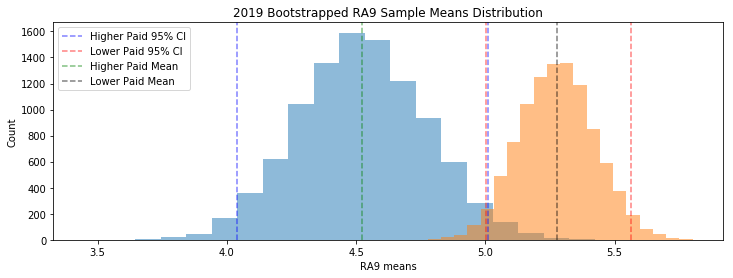

In [239]:
# Let's bootstrap the samples from 2019 since this is the year where there seems to be more observed
# failures by elite pitchers who signed a larger contract.

#bootstrap(idx, percentile, col_name, n_sims = 10000) 10000 as default
data.bootstrap(0, 80, 'RA9')

In [240]:
data.bootstrap_stats()


    The 95% confidence intervals for the higher paid group ranges from 4.039772222222223 to 5.00956111111111.
    The lower paid group ranges from 5.000937853107344 and 5.564077683615818.
    Means of the distribution - 
    Higher Paid Group: 4.522245955555555
    Lower Paid Group:5.277825706214689
     


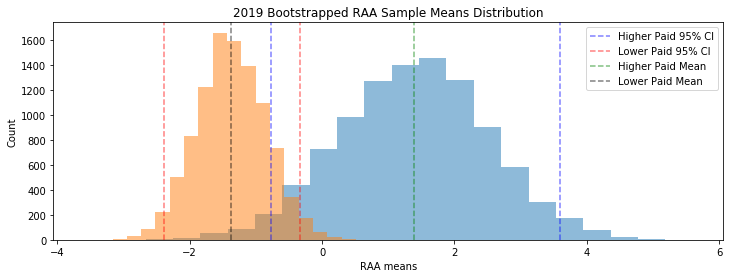

In [241]:
data.bootstrap(0, 80, 'RAA')

In [242]:
data.bootstrap_stats()

# Interesting to note that for this particular group of high paid pitchers in 2019,
# there are some negative means that fall within the 95% confidence interval.
# There is a healthy chance to observe this group performing worse than the average pitcher in the league
# as the RAA performance metric is how many runs better they are compared to the average pitcher in the league.



    The 95% confidence intervals for the higher paid group ranges from -0.7777777777777778 to 3.6.
    The lower paid group ranges from -2.389830508474576 and -0.3389830508474576.
    Means of the distribution - 
    Higher Paid Group: 1.3934644444444442
    Lower Paid Group:-1.3701011299435029
     


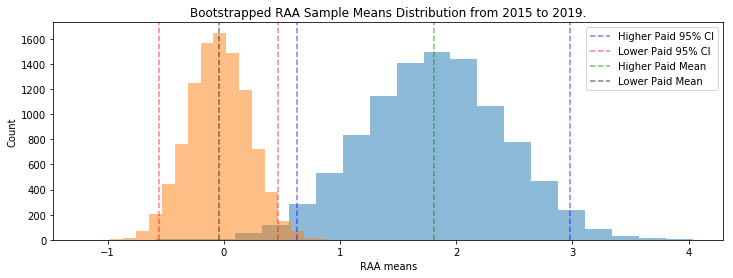

In [17]:
data.bootstrap_sum(80, 'RAA')

In [14]:
data.bootstrap_sum_stats()

#I will say that the actual mean of the population is somewhere around 1.8 for the higher paid
# and 0 for the lower paid pitchers.


    The 95% confidence intervals for the higher paid group ranges from 0.6059113300492611 to 2.9852216748768474.
    The lower paid group ranges from -0.5588599752168525 and 0.45353159851301117.
    Means of the distribution - 
    Higher Paid Group: 1.8007261083743844
    Lower Paid Group:-0.0455909541511772
     


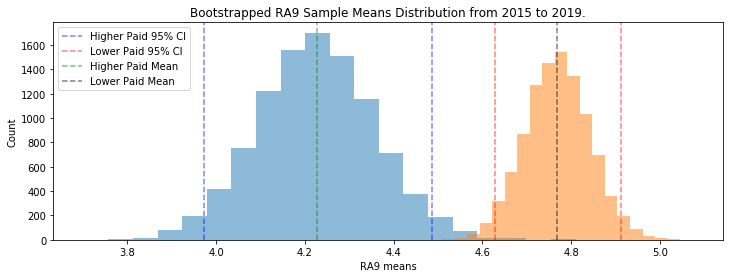

In [274]:
data.bootstrap_sum(80, 'RA9')

In [30]:
# Let's find the Pearson correlation coefficient between salary and some performance metrics
# For year 2019

data.corr(0, 70, 'RAA')

# Do not prove that there is a relationship between salary and performance

For the lower paid pitcher group: The correlation coefficent is 0.21077645192899985 and the p-value is 0.008474721158704807
For the higher paid pitcher group: The correlation coefficent is -0.07903372293183192 and the p-value is 0.5249457853542268


In [31]:
data.corr(0, 80, 'RAA')

# Maybe if I set my significance level to .10 then this might be true.
# Interesting because for the higher paid group in 2019,
# there is a negative correlation between salary and performance.

For the lower paid pitcher group: The correlation coefficent is 0.13909827605755581 and the p-value is 0.06482586361809187
For the higher paid pitcher group: The correlation coefficent is -0.2519783442382054 and the p-value is 0.09495473425562297


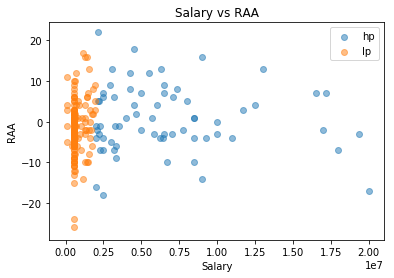

In [19]:
# Let's look at it visually

# Show 70 and 80 percentiles

data.scatter(0,70, 'RAA')

#Ideally you want to see anyone above 5 mil or even 10 mil to be at least above average.

In [21]:
len(data.higher_paid), len(data.lower_paid)

(67, 155)

In [28]:
# Go through a couple of percentiles

data.corr_sum(70, 'RAA')

For the lower paid pitcher group: The correlation coefficent is 0.0624003763771874 and the p-value is 0.09758095701301557
For the higher paid pitcher group: The correlation coefficent is 0.019734160417255196 and the p-value is 0.7318296200996384


In [258]:
# This one is difficult to graph the correlation. 
# Pearsons correlation coefficient is a measure of the linear correlation between 2 variables.
# Without adjusting salaries for inflation by year, it will be difficult to see a linear relationship.
# Higher paid pitchers in 2015 might be in the lower paid group as a whole, or vice versa
# In 2015, the highest paid reliever was getting 10million, vs 20 mil in 2019.

data.dfs[0].Salary.max(), data.dfs[2].Salary.max(), data.dfs[4].Salary.max()

(20000000, 17200000, 10000000)

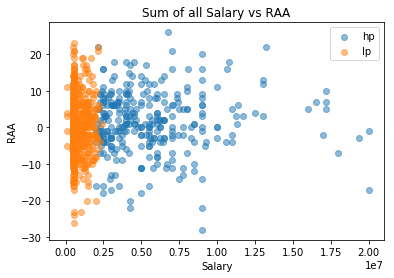

In [55]:
#show 70, 80, 90 percentiles

data.sum_data(70, 'RAA') #need to set higher_paid_sum and lower_paid_sums

fig, ax = plt.subplots()
ax.scatter(data.higher_paid_sum.Salary, data.higher_paid_sum.RAA, alpha =0.5, label='hp')
ax.scatter(data.lower_paid_sum.Salary, data.lower_paid_sum.RAA, alpha=0.5, label='lp')
ax.set_title('Sum of all Salary vs RAA')
ax.set_xlabel('Salary')
ax.set_ylabel('RAA')
ax.legend()
